In [141]:
# Importing libraries

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import monotonically_increasing_id, to_timestamp, row_number, rand, col, date_format, when
from pyspark.sql.window import Window
import glob
import subprocess
import pandas as pd
import pyarrow.hdfs as hdfs
from statsmodels.tsa.arima.model import ARIMA         # Import ARIMA for prediction modelling
from statsmodels.graphics.tsaplots import plot_pacf   # Import plot_pacf for partial auto-correlation plot

In [59]:


data_path = "/home/hduser/Desktop/CA2/Data/Unzipped/"
hdfs_data_path = "/CA2/Data/Unzipped/"
columns = ["dailyRecordId","userid","tweetid","text","hashtags","language"]
schema = StructType([StructField(col, StringType(), True) for col in columns])
datetimeHeader = "tweetcreatedts"
columns.append(datetimeHeader)
print(columns)
datetimeColumn = StructField(datetimeHeader, TimestampType(), True)
schema = StructType(schema.fields + [datetimeColumn])

spark = SparkSession.builder.appName("CSVtoSpark").getOrCreate()
fs = hdfs.connect(host='localhost', port=9000, user='hduser')


['dailyRecordId', 'userid', 'tweetid', 'text', 'hashtags', 'language', 'tweetcreatedts']


/tmp/ipykernel_6709/4159024334.py:21: FutureWarning: pyarrow.hdfs.connect is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  fs = hdfs.connect(host='localhost', port=9000, user='hduser')


In [60]:
def loadNormalisedDf(path):
    temp_df = spark.read.csv(path, header=True)
    return temp_df

def setColumns(df):
    df = df.withColumnRenamed("_c0", "dailyRecordId")
    df = df.withColumn('timestamp',
                   when(to_timestamp(datetimeHeader, 'yyyy-MM-dd HH:mm:ss.SSSSSS').isNotNull(),
                        to_timestamp(datetimeHeader, 'yyyy-MM-dd HH:mm:ss.SSSSSS'))
                   .when(to_timestamp(datetimeHeader, 'MMM-dd-yyyy HH:mm:ss').isNotNull(),
                         to_timestamp(datetimeHeader, 'MMM-dd-yyyy HH:mm:ss')))
    df = df.withColumn(datetimeHeader, date_format(datetimeHeader, "yyyy-MM-dd"))
    df = df.filter(df.tweetcreatedts.isNotNull())
    result_df = df.select(columns).filter("language = 'en'")
    sampled_df = result_df.sample(0.001, seed=42).limit(30)   
    return sampled_df

def takeSamplePerDate(df, noOfSamples):
    print("Number of records before filtering is " + str(df.count()))
    w = Window.partitionBy(datetimeHeader).orderBy(rand())
    df_with_id = df.withColumn('row_id', row_number().over(w))
    df_with_id = df_with_id.filter(df_with_id.row_id <= noOfSamples)
    print("Number of records after filtering is " + str(df_with_id.count()))
    return df_with_id.drop('row_id')

# this method ignores the value of datetimeHeader and must be updated manually if that value changes
def RemoveNullDates(df):
    date = df.filter(df.tweetcreatedts.isNotNull()).select("tweetcreatedts").first()[0]
    return df.fillna({"tweetcreatedts": date})

In [61]:
def getAllFilePaths(directory):
    files = glob.glob(directory + "*.csv")
    print(files)
    return files

def getAllHdfsPaths(hdfs_directory):
    # declare the hadoop fs -ls command to list all CSV files in the directory
    cmd = "hadoop fs -ls {}/*.csv | awk '{{print $NF}}'".format(hdfs_data_path)
    
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    
    output = proc.stdout.read().decode() # read output and decode byte stream
    output = output.strip().split() # remove whitespace and convert to array and return
    return output

#print(csv_paths)

In [62]:
df_combined = spark.createDataFrame([], schema)
panda_df = pd.DataFrame()
for path in getAllHdfsPaths(data_path):
    if fs.exists(path):
        new_df = loadNormalisedDf(path)
        new_df = setColumns(new_df)
        converted_df = new_df.toPandas()       
        panda_df = pd.concat([panda_df, converted_df], ignore_index=True)
print(panda_df.shape)

2023-05-04 21:54:39,952 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0401_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:54:44,504 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0402_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:54:48,117 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 21:56:26,358 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0425_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:56:29,465 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0426_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:56:32,614 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 21:57:59,097 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0521_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:58:08,746 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0522_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:58:18,110 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:01:44,472 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0616_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:01:50,094 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0617_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:01:55,641 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:03:47,609 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0710_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:03:51,861 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0711_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:03:56,761 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:05:29,462 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0803_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:05:35,328 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0804_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:05:39,165 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:06:20,217 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0827_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:06:21,503 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0828_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:06:22,624 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:07:00,677 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0920_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:07:03,921 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0921_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:07:08,638 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:07:58,419 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1014_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:07:59,988 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1015_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:08:01,500 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:08:33,381 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1107_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:08:35,049 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1108_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:08:36,404 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:09:12,969 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1201_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:09:14,614 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1202_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:09:16,388 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:09:50,173 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1225_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:09:52,362 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1226_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:09:53,899 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:10:25,458 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230118_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:10:26,816 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230119_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:10:28,185 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/C

2023-05-04 22:12:17,496 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230305_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:12:20,853 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230306_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:12:25,023 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/C

2023-05-04 22:15:16,104 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230421_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:15:17,393 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230422_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:15:19,152 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/C

2023-05-04 22:16:19,141 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/UkraineCombinedTweetsDeduped_MAR13.csv
2023-05-04 22:16:21,519 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/UkraineCombinedTweetsDeduped_MAR14.csv
2023-05-04 22:16:24,100 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Dat

(7504, 7)


In [63]:
panda_df.head(4)

,dailyRecordId,userid,tweetid,text,hashtags,language,tweetcreatedts
0,27067,891030643135610881,1509720862840213509,"""#Ukraine: Various previously unseen Russian l...","[{'text': 'Ukraine', 'indices': [15, 23]}, {'t...",en,2022-04-01
1,27551,1166303518870761473,1509721671787196444,"""#Ukraine: Another Ukrainian ambush against Ru...","[{'text': 'Ukraine', 'indices': [15, 23]}, {'t...",en,2022-04-01
2,28405,1496705355988054016,1509723106574749701,#Ukraine: Here is video from this position in ...,"[{'text': 'Ukraine', 'indices': [15, 23]}, {'t...",en,2022-04-01
3,31154,23917612,1509727113917739013,Fascist Russia has neither legal nor moral rig...,"[{'text': 'Ukraine', 'indices': [90, 98]}, {'t...",en,2022-04-01


In [64]:
panda_df = panda_df.sort_values(by='tweetcreatedts')

In [67]:
print(panda_df['tweetcreatedts'].head(1))
print(panda_df['tweetcreatedts'].tail(1))
print(panda_df.size)
print(panda_df.shape)

6513    2022-02-24
Name: tweetcreatedts, dtype: object
6483    2023-04-28
Name: tweetcreatedts, dtype: object
52528
(7504, 7)


In [70]:
unique_count = panda_df['tweetcreatedts'].nunique()
print(unique_count)

422


In [66]:
def testSingleFile(path): 
    print(path)
    new_df = loadNormalisedDf(path)
    #new_df = setColumns(new_df)
    df = new_df.withColumnRenamed("_c0", "dailyRecordId")
    #df.select('tweetcreatedts').show()
    #df.show()
    #df = df.withColumn(datetimeHeader, to_timestamp(datetimeHeader, "yyyy-MM-dd HH:mm:ss.SSSSSS"))
    
    df = df.withColumn(datetimeHeader, date_format(datetimeHeader, "yyyy-MM-dd"))
    df = df.filter(df.tweetcreatedts.isNotNull())
    #df.show()
    
    df.select('tweetcreatedts').show()
    #result_df = df.select(columns).filter("language = 'en'")
    #sampled_df = result_df.sample(0.001, seed=42).limit(30)   
    
    
#files = getAllHdfsPaths(data_path)
#path = files[-1]
#testSingleFile('/CA2/Data/Unzipped/20230106_UkraineCombinedTweetsDeduped.csv')

In [71]:
import os

# get the current working directory
cwd = os.getcwd()

# print the current working directory
print("Current working directory:", cwd)

Current working directory: /home/hduser/Desktop/CA2


In [73]:

# save the dataframe to a CSV file
panda_df.to_csv('outputWithoutIndex.csv', index=False)
panda_df.to_csv('outputWithIndex.csv', index=True)

In [2]:
# Load in csv
df = pd.read_csv('outputWithIndex.csv')

In [46]:
# Initial exploratory data anaylsis
df.head()

,Unnamed: 0,dailyRecordId,userid,tweetid,text,hashtags,language,tweetcreatedts
0,6513,220323,1298290459459149824,1496932267863654400,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,"[{'text': 'RussiaUkraine', 'indices': [67, 81]...",en,2022-02-24
1,6512,220106,1429579691258650624,1496932211097931778,#Ukraine #Russia I think we should let @Hasbul...,"[{'text': 'Ukraine', 'indices': [0, 8]}, {'tex...",en,2022-02-24
2,6511,217550,1265082391179202561,1496928912219193344,Russian media reports that “No to war” graffit...,"[{'text': 'Moscow', 'indices': [95, 102]}]",en,2022-02-24
3,6510,215047,1177659309213257728,1496926647911858176,@StratcomCentre Kick some fucking ass #Ukraine,"[{'text': 'Ukraine', 'indices': [38, 46]}]",en,2022-02-24
4,6509,191232,2601989537,1496906278416834563,Do the Russian people like #putin ? #russia,"[{'text': 'putin', 'indices': [27, 33]}, {'tex...",en,2022-02-24


In [47]:
df.shape # 7504 rows and 8 columns

(7504, 8)

In [48]:
df.dtypes

Unnamed: 0         int64
dailyRecordId     object
userid            object
tweetid            int64
text              object
hashtags          object
language          object
tweetcreatedts    object
dtype: object

In [49]:
df.dtypes

Unnamed: 0         int64
dailyRecordId     object
userid            object
tweetid            int64
text              object
hashtags          object
language          object
tweetcreatedts    object
dtype: object

In [50]:
df.describe(include=object)

,dailyRecordId,userid,text,hashtags,language,tweetcreatedts
count,7504,7504,7504,7504,7504,7504
unique,7372,6598,6910,5654,1,422
top,50558,236770150,I’m DONE talking. #JoinTheLegion #StopRussi...,[],en,2022-02-28
freq,4,21,13,510,7504,60


In [51]:
df.describe()

,Unnamed: 0,tweetid
count,7504.000000,7.504000e+03
mean,3751.500000,1.557782e+18
std,2166.362543,4.649140e+16
min,0.000000,1.496778e+18
25%,1875.750000,1.519924e+18
50%,3751.500000,1.544212e+18
75%,5627.250000,1.593299e+18
max,7503.000000,1.651999e+18


In [52]:
# dealing with null values
df.isnull().values.any()

False

In [53]:
# Natural language processing
# extracting number of words per tweet
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

In [54]:
df[['text','word_count']].head()

,text,word_count
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,11
1,#Ukraine #Russia I think we should let @Hasbul...,16
2,Russian media reports that “No to war” graffit...,16
3,@StratcomCentre Kick some fucking ass #Ukraine,6
4,Do the Russian people like #putin ? #russia,9


In [55]:
df['char_count'] = df['text'].str.len() 

In [56]:
## this also includes spaces
df[['text','char_count']].head()

,text,char_count
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,94
1,#Ukraine #Russia I think we should let @Hasbul...,101
2,Russian media reports that “No to war” graffit...,112
3,@StratcomCentre Kick some fucking ass #Ukraine,46
4,Do the Russian people like #putin ? #russia,44


In [57]:
# average word length per tweet
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [58]:
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))

In [59]:
df[['text','avg_word']].head()

,text,avg_word
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,7.636364
1,#Ukraine #Russia I think we should let @Hasbul...,5.375000
2,Russian media reports that “No to war” graffit...,6.062500
3,@StratcomCentre Kick some fucking ass #Ukraine,6.833333
4,Do the Russian people like #putin ? #russia,4.500000


In [60]:
# number of stop words
#!pip install nltk


In [61]:
import nltk

In [62]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [64]:
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head()

,text,stopwords
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,1
1,#Ukraine #Russia I think we should let @Hasbul...,7
2,Russian media reports that “No to war” graffit...,5
3,@StratcomCentre Kick some fucking ass #Ukraine,1
4,Do the Russian people like #putin ? #russia,1


In [65]:
# special characters
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df[['text','hastags']].head()

,text,hastags
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,2
1,#Ukraine #Russia I think we should let @Hasbul...,2
2,Russian media reports that “No to war” graffit...,1
3,@StratcomCentre Kick some fucking ass #Ukraine,1
4,Do the Russian people like #putin ? #russia,2


In [66]:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head(20)

,text,numerics
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,0
1,#Ukraine #Russia I think we should let @Hasbul...,0
2,Russian media reports that “No to war” graffit...,0
3,@StratcomCentre Kick some fucking ass #Ukraine,0
4,Do the Russian people like #putin ? #russia,0
5,Rocket launch from Russian Krasnodar towards #...,0
6,Place of battle. Russian and Ukrainian armored...,0
7,So what's the over/under on #NATO involvement,0
8,In the 24 hours after Putin recognized two bre...,1
9,#USA trying to help #Ukraine https://t.co/UXqB...,0


In [67]:
# number of capitalised words
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['text','upper']].head()

,text,upper
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,2
1,#Ukraine #Russia I think we should let @Hasbul...,1
2,Russian media reports that “No to war” graffit...,0
3,@StratcomCentre Kick some fucking ass #Ukraine,0
4,Do the Russian people like #putin ? #russia,0


In [68]:
# Precprocessing: turn all text into lower case
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'].head()

0    my heart breaks for ukraine. stay strong. 🇺🇦🇮🇱...
1    #ukraine #russia i think we should let @hasbul...
2    russian media reports that “no to war” graffit...
3       @stratcomcentre kick some fucking ass #ukraine
4          do the russian people like #putin ? #russia
Name: text, dtype: object

In [69]:
# remove punctuation
df['text'] = df['text'].str.replace('[^\w\s#@]','')
df['text'].head()
# for some reason this code did not remove the # and @ symbols as it did in David's script

0    my heart breaks for ukraine. stay strong. 🇺🇦🇮🇱...
1    #ukraine #russia i think we should let @hasbul...
2    russian media reports that “no to war” graffit...
3       @stratcomcentre kick some fucking ass #ukraine
4          do the russian people like #putin ? #russia
Name: text, dtype: object

In [70]:
import string
# Define a function to remove all punctuation characters
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Apply the function to the text column
df['text'] = df['text'].apply(remove_punctuation)

print(df)

      Unnamed: 0 dailyRecordId               userid              tweetid   
0           6513        220323  1298290459459149824  1496932267863654400  \
1           6512        220106  1429579691258650624  1496932211097931778   
2           6511        217550  1265082391179202561  1496928912219193344   
3           6510        215047  1177659309213257728  1496926647911858176   
4           6509        191232           2601989537  1496906278416834563   
...          ...           ...                  ...                  ...   
7499        6479         83535            815836723  1650623150730747909   
7500        6480         62759  1262482848768045060  1650901338711117824   
7501        6481         46449   959907715094122497  1651268007199490066   
7502        6482         47276            134189106  1651629845212798980   
7503        6483         43608  1498004265603850247  1651998728943808533   

                                                   text   
0     my heart breaks for uk

In [71]:
# removign the stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0    heart breaks ukraine stay strong 🇺🇦🇮🇱 russiauk...
1    ukraine russia think let hasbullahive abdurozi...
2    russian media reports “no war” graffitis appea...
3              stratcomcentre kick fucking ass ukraine
4                     russian people like putin russia
Name: text, dtype: object

In [72]:
# identifying the 10 most common words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
freq

ukraine      3515
russia       1808
russian      1502
amp           963
war           865
ukrainian     777
putin         706
people        510
us            505
world         464
Name: count, dtype: int64

In [73]:
# choosing not to remove the most common words as they may help in the calssification of data

In [74]:
# dealing with rare words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-1000:]
freq

🇺🇦ukrainerussianwar    1
amman                  1
🇯🇴                     1
tajlifestylecenter     1
naturalpackaging       1
                      ..
discover               1
📌                      1
erhn                   1
httpstcop9nyrqwqbj     1
httpstcokadl1agzpw     1
Name: count, Length: 1000, dtype: int64

In [75]:
total_words = df['text'].str.split().apply(len).sum()
print(f"Total number of words in the 'text' column: {total_words}")

Total number of words in the 'text' column: 133535


In [76]:
# Rare words can cause noise or loss of signal in the analysis.In this dataset there are likely a large number of 
# rare words. However, they may also be important for understanding the sentiment analysis. 

# Going to make two dataset and sentiment analysis, to see how the rare words affect the outcome.
# Based on looking at the freq output (and changing the output) it looks like it would be better to remove the
# the rare words. But I'll conduct the analysis and see.

In [77]:
# see how many times ur comes up
# pattern to match standalone "ur"

import re

pattern = r"(?<!\S)ur(?!\S)"

# function to count "ur" as a standalone word
def count_ur(text):
    return len(re.findall(pattern, text))

# apply the count_ur function to the 'text' column and sum the results
ur_count = df['text'].apply(count_ur).sum()

# print the total count of "ur" as a standalone word
print(ur_count)

5


In [78]:
# Remove the word ur and replace with your
# pattern to match standalone "ur"
pattern = r"(?<!\S)ur(?!\S)"

# function to replace "ur" with "your"
def replace_ur(text):
    return re.sub(pattern, "your", text)

# replace "ur" with "your" using the pattern and function
df['text'] = df['text'].apply(replace_ur)

In [79]:
# apply the count_ur function to the 'text' column and sum the results
ur_count = df['text'].apply(count_ur).sum()

# print the total count of "ur" as a standalone word
print(ur_count)

0


In [35]:
# Correcting spelling mistakes
# installing textblob
#!pip install -U textblob 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 KB 3.1 MB/s eta 0:00:00 MB/s eta 0:00:01


In [80]:
#from textblob import TextBlob
#df['text'].apply(lambda x: str(TextBlob(x).correct()))

KeyboardInterrupt: 

In [ ]:
# stopped the textblob corrections. The size the of the dataframe was too big. 

In [83]:
#!pip install nltk.sentiment.vader

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement nltk.sentiment.vader (from versions: none)
ERROR: No matching distribution found for nltk.sentiment.vader


In [7]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [49]:
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def percentage(part, whole):
    return 100 * float(part) / float(whole)


# noOfTweet = int(input("10"))
# noOfTweet = int(input("100"))
noOfTweet = len(df['text'])
#tweet_list = df['text'].tolist()
tweet_list = [(row['text'], row['tweetcreatedts']) for _, row in df.iterrows()]
positive = 0
negative = 0
neutral = 0
polarity = 0
neutral_list = []
negative_list = []
positive_list = []
dateAndScore_list = []

counter = 0

for tweet_text in tweet_list:
    counter += 1
    analysis = TextBlob(tweet_text[0])
    score = SentimentIntensityAnalyzer().polarity_scores(tweet_text[0])
    neg = score['neg']
    #print("Negative score is " + str(neg))
    neu = score['neu']
    #print("Neutral score is " + str(neu))
    pos = score['pos']
    #print("Positive score is " + str(pos))
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    if neg > pos:
        negative_list.append(tweet_text[1])
        negative += 1
        dateAndScore_list.append([tweet_text[1], "neg"])
    elif pos > neg:
        positive_list.append(tweet_text[1])
        positive += 1
        dateAndScore_list.append([tweet_text[1], "pos"])
    elif pos == neg:
        neutral_list.append(tweet_text[1])
        neutral += 1
        dateAndScore_list.append([tweet_text[1], "neu"])
    
print("neutral = " + str(neutral))
print("positive = " + str(positive))
print("negative = " + str(negative))

KeyError: 'text'

In [9]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  7504
positive number:  2505
negative number:  3455
neutral number:  1544


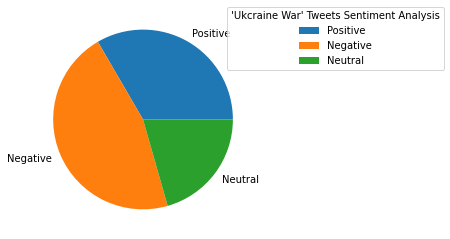

In [10]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([len(positive_list), len(negative_list), len(neutral_list)])
mylabels = ["Positive", "Negative", "Neutral"]

plt.pie(y, labels = mylabels)
plt.legend(title = "'Ukcraine War' Tweets Sentiment Analysis", loc="upper left", bbox_to_anchor=(0.85,1.025), )
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
plt.show() 

In [11]:
# Time series Analysis
#!pip install scikit-learn

In [12]:

from statsmodels.tsa.arima.model import ARIMA         # Import ARIMA for prediction modelling
from statsmodels.graphics.tsaplots import plot_pacf   # Import plot_pacf for partial auto-correlation plot
from pandas.plotting import autocorrelation_plot      # Import autocorrelation_plot for auto-correlation plot
from sklearn.metrics import accuracy_score            # Import accuracy_score for checking accuracy of model

In [64]:
df = pd.DataFrame(dateAndScore_list, columns=['Date', 'Analysis'])

#date_analysis_count = df.groupby('Date')['Analysis'].value_counts()
#positive_percentage = (date_analysis_count.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).loc[:, 'pos']
#positive_percentage = (date_analysis_count.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).get(('pos'), 0)
positive_percentage = df.groupby('Date')['Analysis'].apply(lambda x: (x == 'pos').mean() * 100)


#print(date_analysis_count)
print(type(positive_percentage))
print(positive_percentage)


<class 'pandas.core.series.Series'>
Date
2022-02-24     20.000000
2022-02-27     40.000000
2022-02-28     33.333333
2022-03-01     23.333333
2022-03-02     46.666667
                 ...    
2023-04-24      0.000000
2023-04-25    100.000000
2023-04-26      0.000000
2023-04-27    100.000000
2023-04-28      0.000000
Name: Analysis, Length: 422, dtype: float64


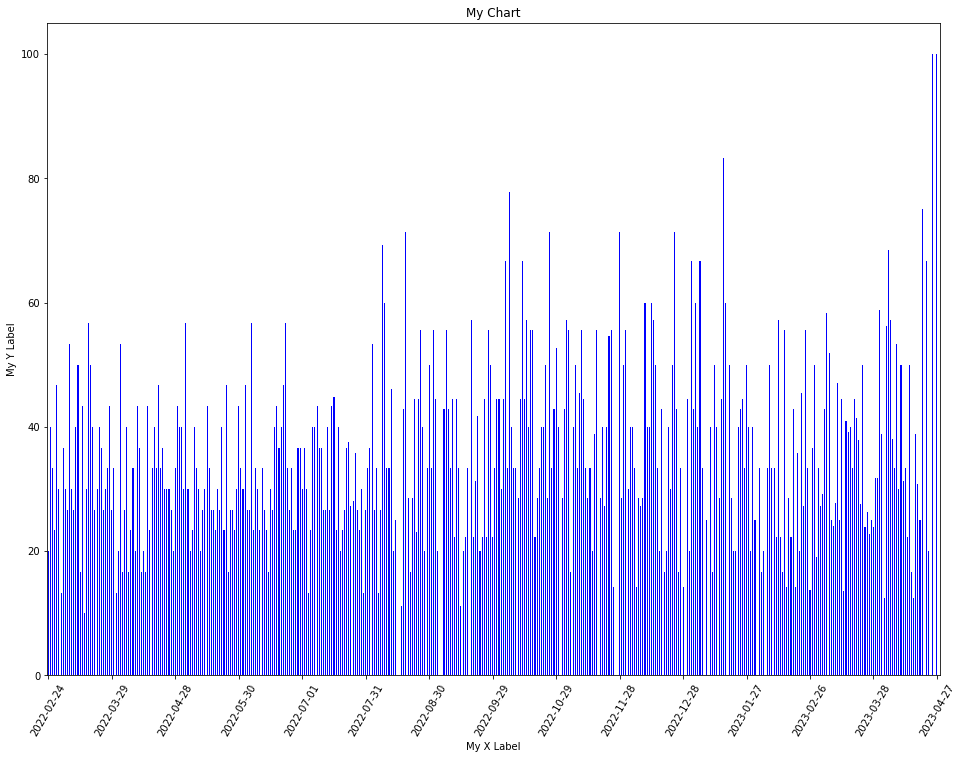

In [65]:
ax = positive_percentage.plot.bar(color='blue', title='My Chart', xlabel='My X Label', ylabel='My Y Label', figsize=(16, 12))

ax.set_xticks(ax.get_xticks()[::30])
plt.xticks(rotation=60)
plt.show()

In [66]:
# Create a dataframe of the positive tweets
df_pos = pd.DataFrame(positive_percentage)
df_pos.reset_index(inplace=True)
df_pos.columns = ['Date', 'Positive Percentage']

In [67]:
df_pos.head()

,Date,Positive Percentage
0,2022-02-24,20.000000
1,2022-02-27,40.000000
2,2022-02-28,33.333333
3,2022-03-01,23.333333
4,2022-03-02,46.666667


In [68]:
df_pos.dtypes

Date                    object
Positive Percentage    float64
dtype: object

In [69]:
# change Date to a datetime
df_pos['Date'] = pd.to_datetime(df_pos['Date'], format='%Y-%m-%d')

df_pos.head()

,Date,Positive Percentage
0,2022-02-24,20.000000
1,2022-02-27,40.000000
2,2022-02-28,33.333333
3,2022-03-01,23.333333
4,2022-03-02,46.666667


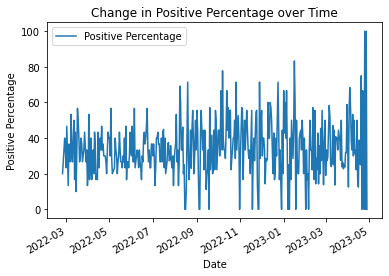

In [70]:
df_pos.plot(x="Date", y="Positive Percentage")
plt.title("Change in Positive Percentage over Time")
plt.xlabel("Date")
plt.ylabel("Positive Percentage")
plt.show()

In [71]:
# set and sort the index
df_pos = df_pos.set_index('Date')
df_pos = df_pos.asfreq('D')
df_pos = df_pos.sort_index()
df_pos.head()

,Positive Percentage
Date,
2022-02-24,20.000000
2022-02-25,NaN
2022-02-26,NaN
2022-02-27,40.000000
2022-02-28,33.333333


In [72]:
print(f'Number of rows with missing values: {df_pos.isnull().any(axis=1).sum()}')

Number of rows with missing values: 7


In [73]:
missing_rows = df_pos[df_pos.isnull().any(axis=1)]
print(missing_rows)

            Positive Percentage
Date                           
2022-02-25                  NaN
2022-02-26                  NaN
2022-03-28                  NaN
2022-05-06                  NaN
2022-05-07                  NaN
2022-06-07                  NaN
2022-06-08                  NaN


In [23]:
#df_pos = df_pos.fillna(0)

In [24]:
#print(f'Number of rows with missing values: {df_pos.isnull().any(axis=1).sum()}')
# Filled the 7 empty rows with zero values

Number of rows with missing values: 0


In [ ]:
# further down the script discovered that d = 0 meaning the mean, variance and covariance does not change in
# this data set. 
# For this reason, I think I will fill the NaN values with the mean rather than 0. 

In [60]:
means = df_pos.mean()
print(means)

Positive Percentage    34.190547
dtype: float64


In [74]:
df_pos = df_pos.fillna(34.190547)

In [75]:
df_pos.head()

,Positive Percentage
Date,
2022-02-24,20.000000
2022-02-25,34.190547
2022-02-26,34.190547
2022-02-27,40.000000
2022-02-28,33.333333


In [98]:
# Find the indices of the zero values
zero_indices = np.where(df_pos['Positive Percentage'] == 0)[0]

# Print the indices of the zero values
print("Indices of zero values:", zero_indices)

# can't use the Multiplicative decomposition because there are zeros in my data.

Indices of zero values: [172 173 192 193 206 249 267 275 276 308 317 319 328 342 346 421 424 426
 428]


In [ ]:
# Decomposing Time Series into it's components

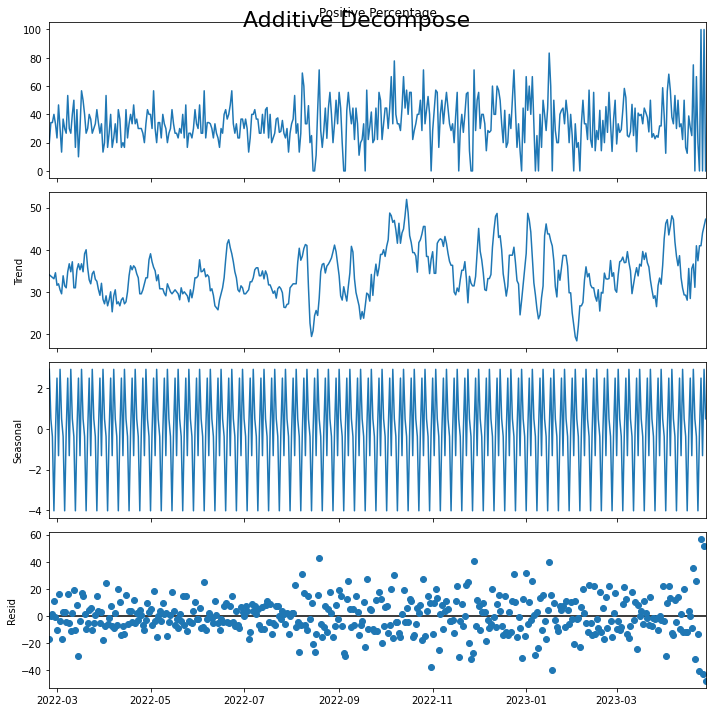

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
%matplotlib inline

# Multiplicative Decomposition 
#result_mul = seasonal_decompose(df_pos['Positive Percentage'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_pos['Positive Percentage'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [100]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2022-02-24,2.917761,34.049594,-16.967355,20.000000
2022-02-25,0.487935,33.729376,-0.026764,34.190547
2022-02-26,-0.380127,33.409158,1.161516,34.190547
2022-02-27,-4.026295,33.102061,10.924234,40.000000
2022-02-28,-0.167486,34.530632,-1.029813,33.333333


In [101]:
2.917761 + 34.049594-16.96735

20.000004999999998

In [102]:
# doing the Augmented Dickey Fuller test (ADH Test) whether the time series is stationary
from statsmodels.tsa.stattools import adfuller
# Perform the ADF test
result = adfuller(df_pos['Positive Percentage'])

# Print the test statistics and p-value
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# the significant p-value means we can reject the null hypothesis. It suggests that there is some pattern/trend 
# degree of variation that is not due to random variation.

ADF Statistic: -5.246259
p-value: 0.000007


In [ ]:
# do not need to detrend the time series because it is stationary.
# do not need to deseasonalise the time series because it is stationary

Text(0.5, 1.0, 'Ukraine tweets detrended by subtracting the least squares fit')

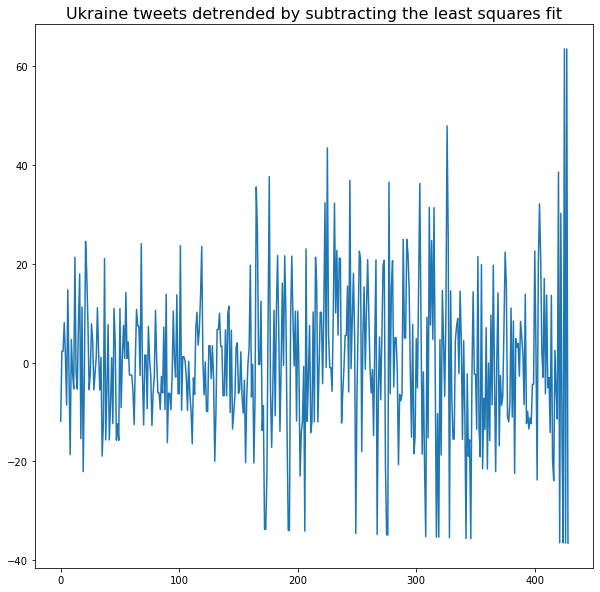

In [104]:
# checking for detrending anyway
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(df_pos['Positive Percentage'].values)
plt.plot(detrended)
plt.title('Ukraine tweets detrended by subtracting the least squares fit', fontsize=16)

In [ ]:
# this plot is showing an overall flatted line, there is no overall curve to the line

Text(0.5, 1.0, 'Ukraine tweets detrended by subtracting the trend component')

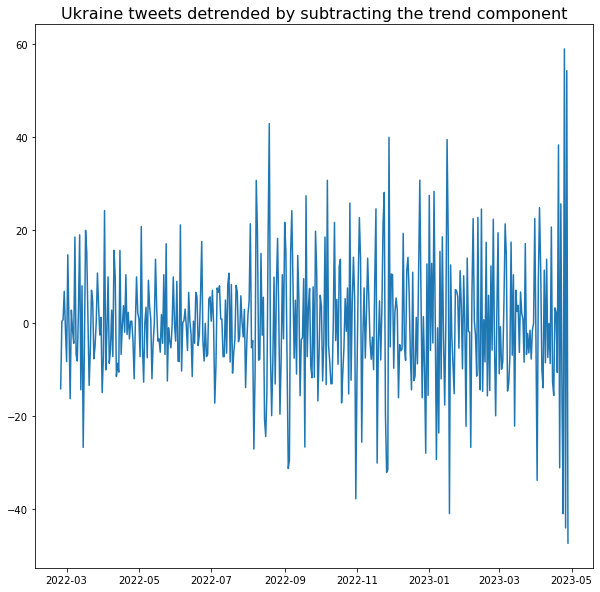

In [105]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df_pos['Positive Percentage'], model='additive', extrapolate_trend='freq')

detrended = df_pos['Positive Percentage'].values - result_add.trend
plt.plot(detrended)
plt.title('Ukraine tweets detrended by subtracting the trend component', fontsize=16)

In [ ]:
# both graphs looks very similar and compared to the plot below of the actual data, the line has been 
# very marginally flattened

<AxesSubplot:xlabel='Date'>

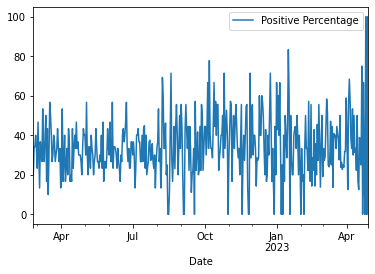

In [76]:
df_pos.plot()

[]

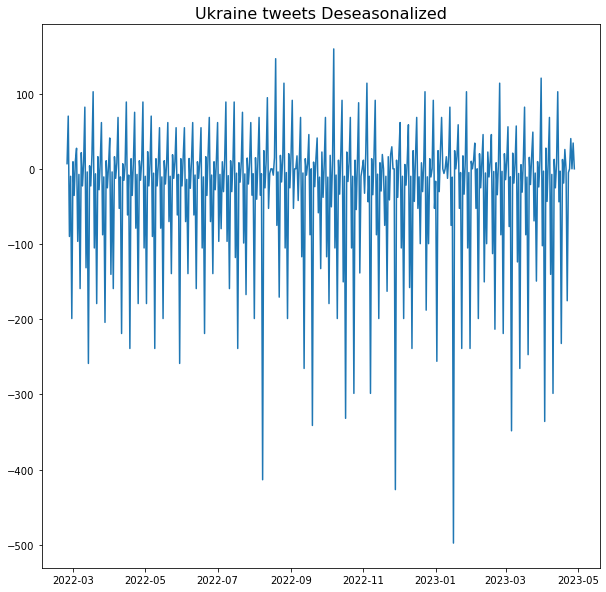

In [106]:
# Investigating deseasonalising the data

# Subtracting the Trend Component
# Time Series Decomposition
result_add = seasonal_decompose(df_pos['Positive Percentage'], model='additive', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df_pos['Positive Percentage'].values/ result_add.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Ukraine tweets Deseasonalized', fontsize=16)
plt.plot()

In [ ]:
# Because I don't believe there was seasonality to this data to begin with, I don't think this was successful.

Train dates : 2022-02-24 00:00:00 --- 2023-03-23 00:00:00  (n=393)
Test dates  : 2023-03-24 00:00:00 --- 2023-04-28 00:00:00  (n=36)


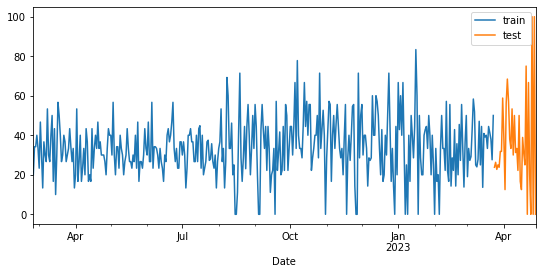

In [108]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = df_pos[:-steps]
data_test  = df_pos[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['Positive Percentage'].plot(ax=ax, label='train')
data_test['Positive Percentage'].plot(ax=ax, label='test')
ax.legend();

In [111]:
!pip install skforecast

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 KB 1.9 MB/s eta 0:00:000:00:010:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 8.3 MB/s eta 0:00:000m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 16.3 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 23.2 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.7/613.7 KB 16.7 MB/s eta 0:00:000:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.1
    Uninstalling pandas-2.0.1:
      Successfully uninstalled pand

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load


In [115]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['Positive Percentage'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-02-24 00:00:00'), Timestamp('2023-03-23 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-07 15:02:11 
Last fit date: 2023-05-07 15:02:11 
Skforecast version: 0.7.0 
Python version: 3.10.6 
Forecaster id: None 

In [116]:
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2023-03-24    33.286180
2023-03-25    29.272989
2023-03-26    35.873146
2023-03-27    33.884683
2023-03-28    28.083175
Freq: D, Name: pred, dtype: float64

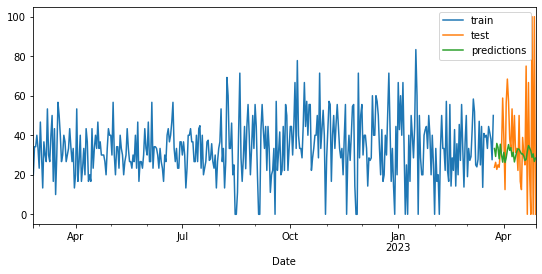

In [117]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Positive Percentage'].plot(ax=ax, label='train')
data_test['Positive Percentage'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# predictions do not look good

In [118]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Positive Percentage'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 669.2822918468964


2023-05-07 20:28:34,036 WARN spark.HeartbeatReceiver: Removing executor driver with no recent heartbeats: 11468045 ms exceeds timeout 120000 ms
2023-05-07 20:28:42,620 WARN executor.Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:103)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala

In [119]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Positive Percentage'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [03:34<00:00, 107.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 284.667021163909



In [120]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",284.667021,3,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",284.996889,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",285.078311,3,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",285.082442,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",286.125664,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",287.227379,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",290.928950,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",291.270767,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",295.001560,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",295.971367,10,500


In [122]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['Positive Percentage'])

In [123]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

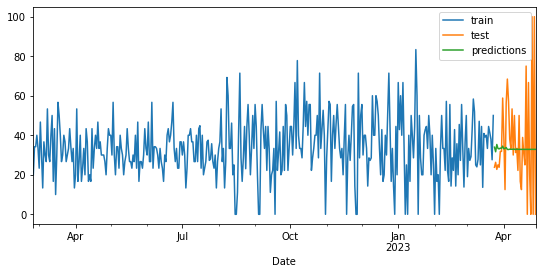

In [124]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Positive Percentage'].plot(ax=ax, label='train')
data_test['Positive Percentage'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [126]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Positive Percentage'],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

Test error (mse): 617.4055735845673


In [144]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = df_pos['Positive Percentage'],
                                    initial_train_size = len(df_pos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                                    )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 321
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   2022-02-24 00:00:00 -- 2023-01-10 00:00:00  (n=321)
    Validation: 2023-01-11 00:00:00 -- 2023-02-15 00:00:00  (n=36)
Data partition in fold: 1
    Training:   2022-02-24 00:00:00 -- 2023-02-15 00:00:00  (n=357)
    Validation: 2023-02-16 00:00:00 -- 2023-03-23 00:00:00  (n=36)
Data partition in fold: 2
    Training:   2022-02-24 00:00:00 -- 2023-03-23 00:00:00  (n=393)
    Validation: 2023-03-24 00:00:00 -- 2023-04-28 00:00:00  (n=36)

Backtest error: 354.0929497411801


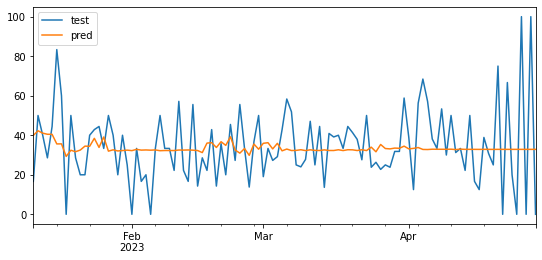

In [148]:
fig, ax = plt.subplots(figsize=(9, 4))
df_pos.loc[predictions_backtest.index, 'Positive Percentage'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [149]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [150]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=df_pos['Positive Percentage'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2022-02-24 00:00:00'), Timestamp('2023-04-28 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-05-07 21:18:30 
Last fit date: 2023-05-07 21:18:31 
Skforecast version: 0.7.0 
Python version: 3.10.6 


In [151]:
print(forecaster.source_code_create_predictors)

def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors



In [152]:
X, y = forecaster.create_train_X_y(y=df_pos['Positive Percentage'])
X.head(4)

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
Date,,,,,,,,,,,
2022-03-16,10.000000,43.333333,16.666667,50.000000,40.000000,26.666667,30.000000,53.333333,26.666667,30.000000,31.919055
2022-03-17,30.000000,10.000000,43.333333,16.666667,50.000000,40.000000,26.666667,30.000000,53.333333,26.666667,32.419055
2022-03-18,56.666667,30.000000,10.000000,43.333333,16.666667,50.000000,40.000000,26.666667,30.000000,53.333333,33.542861
2022-03-19,50.000000,56.666667,30.000000,10.000000,43.333333,16.666667,50.000000,40.000000,26.666667,30.000000,34.333333


In [153]:
y.head(4)

Date
2022-03-16    30.000000
2022-03-17    56.666667
2022-03-18    50.000000
2022-03-19    40.000000
Freq: D, Name: y, dtype: float64

In [154]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

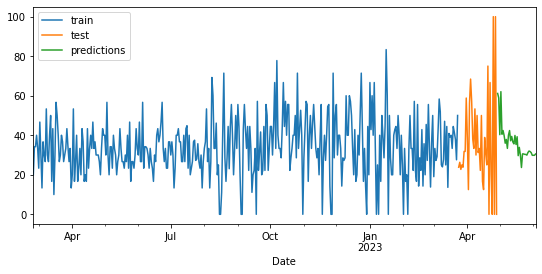

In [155]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Positive Percentage'].plot(ax=ax, label='train')
data_test['Positive Percentage'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [156]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Positive Percentage'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 711.0734523346518


In [157]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['Positive Percentage'],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 6.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [01:49<00:00, 109.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 275.51768783166216



In [158]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",275.517688,3,100
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",276.386721,3,500
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",279.696535,5,500
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",280.479429,5,100
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",287.614718,10,500
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",293.034033,10,100


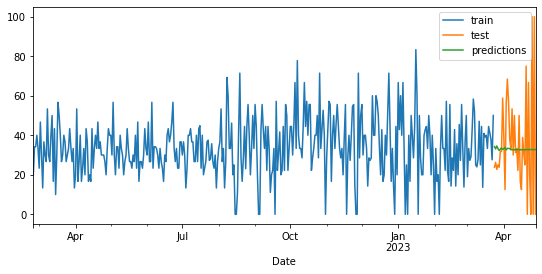

In [159]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Positive Percentage'].plot(ax=ax, label='train')
data_test['Positive Percentage'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

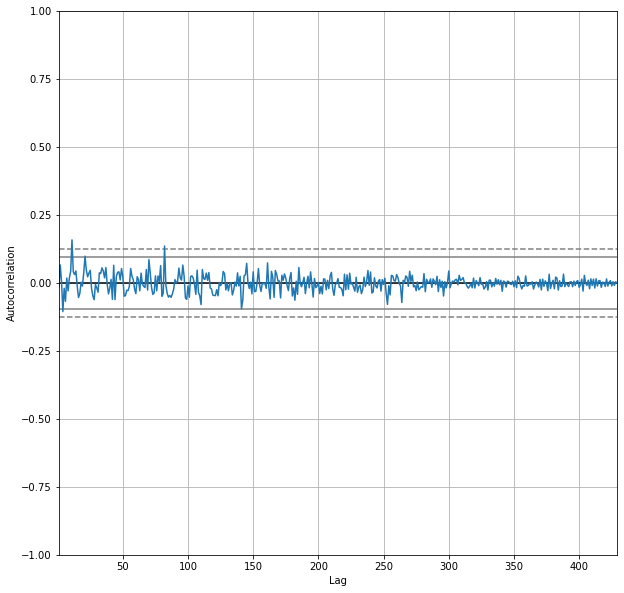

In [127]:
# trying code from my previous asignment, but I don't think it's going to work
autocorrelation_plot(df_pos)
# p value is 2 because the curve crosses on the second boundary

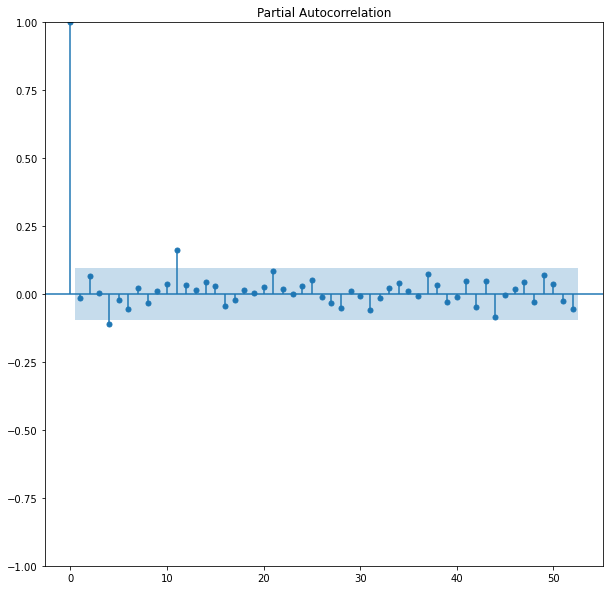

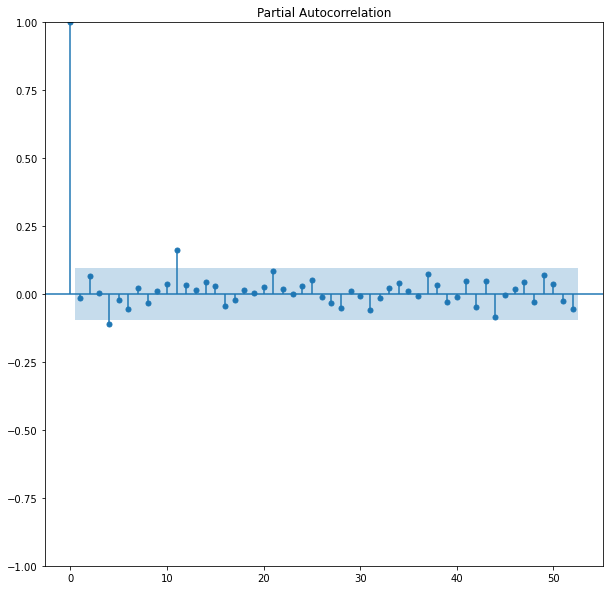

In [128]:
plot_pacf(df_pos, lags = 52)
# q value is 3 as there are three outliers outside the blue box. I'm counting the dot that is predominantly 
# sitting outside the threshold and not counting the dots that are sitting mostly within the threshold

In [129]:
# doing the ADF Fuller test
from statsmodels.tsa.stattools import adfuller
# Perform the ADF test
result = adfuller(df_pos['Positive Percentage'])

# Print the test statistics and p-value
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# the significant p-value means we can reject the null hypothesis. It suggests that there is some pattern/trend 
# degree of variation that is not due to random variation.

ADF Statistic: -5.246259
p-value: 0.000007


In [130]:
#!pip install pmdarima

In [131]:
# calculating the d-value
import pmdarima as pm
d = pm.arima.utils.ndiffs(df_pos['Positive Percentage'], test='adf')

print("The optimal number of differencing operations is: ", d)

The optimal number of differencing operations is:  0


In [132]:
# d = 0, but I thought 0 meant the data was stationary i.e. the mean and variance did not change?
# this should make it easier to make predictions with the data

In [133]:
df_pos.head()

,Positive Percentage
Date,
2022-02-24,20.000000
2022-02-25,34.190547
2022-02-26,34.190547
2022-02-27,40.000000
2022-02-28,33.333333


In [160]:
p, d, q = 2, 5, 3

In [161]:
max(df_pos.index)

Timestamp('2023-04-28 00:00:00')

In [162]:
min(df_pos.index)

Timestamp('2022-02-24 00:00:00')

In [163]:
# diving the data into training and test data
from datetime import datetime


date1 = datetime(2022, 2, 24)
date2 = datetime(2023, 4, 28)

# Calculate the time difference between the two dates
delta = date2 - date1

# Calculate the duration that represents 70% of the time difference
duration = delta * 0.7

# Calculate the date that is 70% of the way between the two dates
date_70_percent = date1 + duration

# Print the result
print(date_70_percent)

2022-12-20 14:24:00


In [164]:
import numpy as np
#cutoffTime = pd.to_datetime("2003", format='%Y')
cutoffTime = np.datetime64('2022-12-20')
print(type(cutoffTime))
print(type(df_pos.index))

train = df_pos[df_pos.index <= cutoffTime]
test = df_pos[df_pos.index > cutoffTime]

<class 'numpy.datetime64'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [209]:
p, d, q = 5, 0, 3

In [210]:
# use seasonal variable as a switch between SARIMA and ARIMA models
#seasonal = True
seasonal = False
if (seasonal):
 model=sm.tsa.statespace.SARIMAX(train,
                                 order=(p, d, q))
 model=model.fit()
else:
    model = ARIMA(train, order=(p,d,q))  
    model = model.fit() 
print(model.summary())

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                SARIMAX Results                                
Dep. Variable:     Positive Percentage   No. Observations:                  300
Model:                  ARIMA(5, 0, 3)   Log Likelihood               -1200.503
Date:                 Sun, 07 May 2023   AIC                           2421.005
Time:                         21:43:06   BIC                           2458.043
Sample:                     02-24-2022   HQIC                          2435.828
                          - 12-20-2022                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.9507      0.900     37.719      0.000      32.187      35.715
ar.L1         -0.3655      0.123     -2.961      0.003      -0.607      -0.124
ar.L2         -0.5858      0.090     -6.526 

/home/hduser/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [211]:
predictions = model.predict(len(train), len(train)+30)
print(predictions)

2022-12-21    34.452308
2022-12-22    27.834964
2022-12-23    32.209842
2022-12-24    37.962037
2022-12-25    38.749592
2022-12-26    30.908528
2022-12-27    29.391832
2022-12-28    33.984318
2022-12-29    38.940134
2022-12-30    35.250411
2022-12-31    30.475587
2023-01-01    30.861682
2023-01-02    36.322459
2023-01-03    37.375482
2023-01-04    33.465234
2023-01-05    30.344585
2023-01-06    33.173888
2023-01-07    36.751085
2023-01-08    35.959110
2023-01-09    32.045128
2023-01-10    31.463851
2023-01-11    34.592758
2023-01-12    36.581964
2023-01-13    34.343150
2023-01-14    31.760317
2023-01-15    32.651938
2023-01-16    35.486813
2023-01-17    35.719259
2023-01-18    33.288651
2023-01-19    32.030534
2023-01-20    33.811568
Freq: D, Name: predicted_mean, dtype: float64


<AxesSubplot:title={'center':'Change in positive sentiment over time'}, xlabel='Date'>

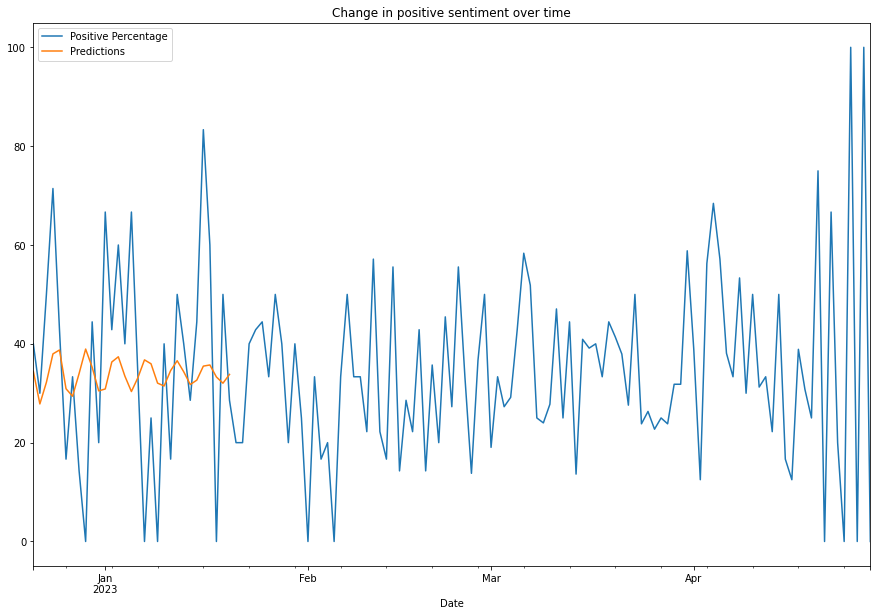

In [212]:
test.plot(legend=True, label="Test Data",figsize=(15, 10), title='Change in positive sentiment over time')
predictions.plot(legend=True, label="Predictions")

In [218]:
from statsmodels.tsa.stattools import grangercausalitytests
positive_percentage = df.groupby('Date')['Analysis'].apply(lambda x: (x == 'pos').mean() * 100)
grangercausalitytests(positive_percentage[['Analysis', 'Date']], maxlag=2)

KeyError: "None of [Index(['Analysis', 'Date'], dtype='object', name='Date')] are in the [index]"

In [217]:
df.head()

,Date,Analysis
0,2022-02-24,pos
1,2022-02-24,neu
2,2022-02-24,neu
3,2022-02-24,neg
4,2022-02-24,pos
